# todo
* any todos go here
* do dummy encoding on any categorical variables and see if any of those help the model
* treat floor, bedroom as categorical

# Outline
* Load in data
* load in libraries
* choose features for modeling
* encode/dummify categorical features IF NEEDED
* build a model that meets the assumptions of an OLS
* cross validate the model with sklearn
* interpret the model 



# Modeling Flow for OLS
* build models in statsmodels until it meets all assumptions
    * build models on all the data 
* build the validated model in sklearn and cross validation test 
* final model 
    * or iterate on it to make it better

# Methodology
Step 1: Develop Functions that will allow you to experiment with ease

    Create a function that builds a model given a target and features
    Create a function that will test Multicollinearity of features in a feature space
    Create a function that will validate the assumptions of OLS

Step 2: Begin EDA and Feature Selection/Engineering/Transforming

Step 3: Experiment with various feature spaces

Step 4: Land on a good model and cross-validate

Step 5: Interpret your final model

    What does it mean in regards to business?
    What does it mean in regards to the math/statistics of the data?
    Is the model good? Does it make sense? Why or why not?
    What data would you like in the future?



In [1]:
# Load in libraries
import warnings
from importlib import reload

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np 

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as sms

from statsFunctions import check_model

from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns


In [2]:
# load in data
df = pd.read_csv('../data/proc_kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view_rank,...,long,sqft_living15,sqft_lot15,date_month,date_day,date_year,renovated_status,sqft_living15_diff,sqft_lot15_diff,scenic_status
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,-122.257,1340,5650,10,13,2014,UNK,-160,0,N
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,...,-122.319,1690,7639,12,9,2014,Y,880,-397,N
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,...,-122.233,2720,8062,2,25,2015,UNK,-1950,1938,N
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0,...,-122.393,1360,5000,12,9,2014,UNK,600,0,N
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0,...,-122.045,1800,7503,2,18,2015,UNK,-120,577,N


In [3]:
print(df.shape)
df.info()

(21420, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21420 entries, 0 to 21419
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  21420 non-null  int64  
 1   date                21420 non-null  object 
 2   price               21420 non-null  float64
 3   bedrooms            21420 non-null  int64  
 4   bathrooms           21420 non-null  float64
 5   sqft_living         21420 non-null  int64  
 6   sqft_lot            21420 non-null  int64  
 7   floors              21420 non-null  float64
 8   waterfront          21420 non-null  int64  
 9   view_rank           21420 non-null  int64  
 10  condition           21420 non-null  int64  
 11  grade               21420 non-null  int64  
 12  sqft_above          21420 non-null  int64  
 13  sqft_basement       21420 non-null  int64  
 14  yr_built            21420 non-null  int64  
 15  yr_renovated        21420 non-null  int64

# Build a model
Get things rolling by creating a model. Doesn't have to be stellar but is your entry point to creating something that's not garbage.

In [5]:
target = 'price'
features_to_use = ['sqft_living', 'view_rank']

In [6]:
ols = check_model(df, features_to_use=features_to_use, target_col=target, show_summary=True)

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.853
Model:                            OLS   Adj. R-squared (uncentered):              0.853
Method:                 Least Squares   F-statistic:                          6.208e+04
Date:                Mon, 12 Oct 2020   Prob (F-statistic):                        0.00
Time:                        19:12:27   Log-Likelihood:                     -2.9672e+05
No. Observations:               21420   AIC:                                  5.935e+05
Df Residuals:                   21418   BIC:                                  5.935e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

# Explore the feature space

In [7]:
# lets find some features based on their correlation scores

def get_columns_correlations(df, target):
    columns_correlations = []
    columns_non_numeric = []
    
    for column in df.drop(columns=[target]).columns:
        try:
            # using .corr on each column to the target
            corr = np.abs(df[column].corr(df[target]))
            t = (column, corr)
            columns_correlations.append(t)
        except:
            columns_non_numeric.append(column)
    return columns_correlations


def get_columns_correlations_above_threshold(all_col_corrs):
    correlated_features_above_2 = [t[0] for t in all_col_corrs if t[1] >= 0.20]
    return correlated_features_above_2

In [8]:
all_columns_correlations = get_columns_correlations(df, target)
all_columns_correlations

[('id', 0.018449520780333174),
 ('bedrooms', 0.3096400152273569),
 ('bathrooms', 0.5252152971165561),
 ('sqft_living', 0.7012948591175873),
 ('sqft_lot', 0.08878895326280657),
 ('floors', 0.254971632871279),
 ('waterfront', 0.26491453896199607),
 ('view_rank', 0.39278723176279356),
 ('condition', 0.03421927419820454),
 ('grade', 0.666834956438976),
 ('sqft_above', 0.6044238993986455),
 ('sqft_basement', 0.3212640164141516),
 ('yr_built', 0.051011811800142234),
 ('yr_renovated', 0.11827845194955379),
 ('zipcode', 0.0511690561394496),
 ('lat', 0.30643893771248304),
 ('long', 0.01982564494658666),
 ('sqft_living15', 0.5837916994556079),
 ('sqft_lot15', 0.08204522248404936),
 ('date_month', 0.007920043895258681),
 ('date_day', 0.014085460291666968),
 ('date_year', 0.0013854043606439264),
 ('sqft_living15_diff', 0.40602839520777456),
 ('sqft_lot15_diff', 0.04975026762471563)]

In [9]:
# let's get all columns with correlation above a threshold of 0.20
correlated_features_above_2 = [t[0] for t in all_columns_correlations if t[1] >= 0.20]
correlated_features_above_2

['bedrooms',
 'bathrooms',
 'sqft_living',
 'floors',
 'waterfront',
 'view_rank',
 'grade',
 'sqft_above',
 'sqft_basement',
 'lat',
 'sqft_living15',
 'sqft_living15_diff']

In [10]:
whole_feature_space = correlated_features_above_2
whole_feature_space.append(target)

In [11]:
# Let's hone in on some promising features
correlated_df = df[whole_feature_space]
correlated_df.head()

,bedrooms,bathrooms,sqft_living,floors,waterfront,view_rank,grade,sqft_above,sqft_basement,lat,sqft_living15,sqft_living15_diff,price
0,3,1.00,1180,1.0,0,0,7,1180,0,47.5112,1340,-160,221900.0
1,3,2.25,2570,2.0,0,0,7,2170,400,47.7210,1690,880,538000.0
2,2,1.00,770,1.0,0,0,6,770,0,47.7379,2720,-1950,180000.0
3,4,3.00,1960,1.0,0,0,7,1050,910,47.5208,1360,600,604000.0
4,3,2.00,1680,1.0,0,0,8,1680,0,47.6168,1800,-120,510000.0


### Plot a scatter matrix

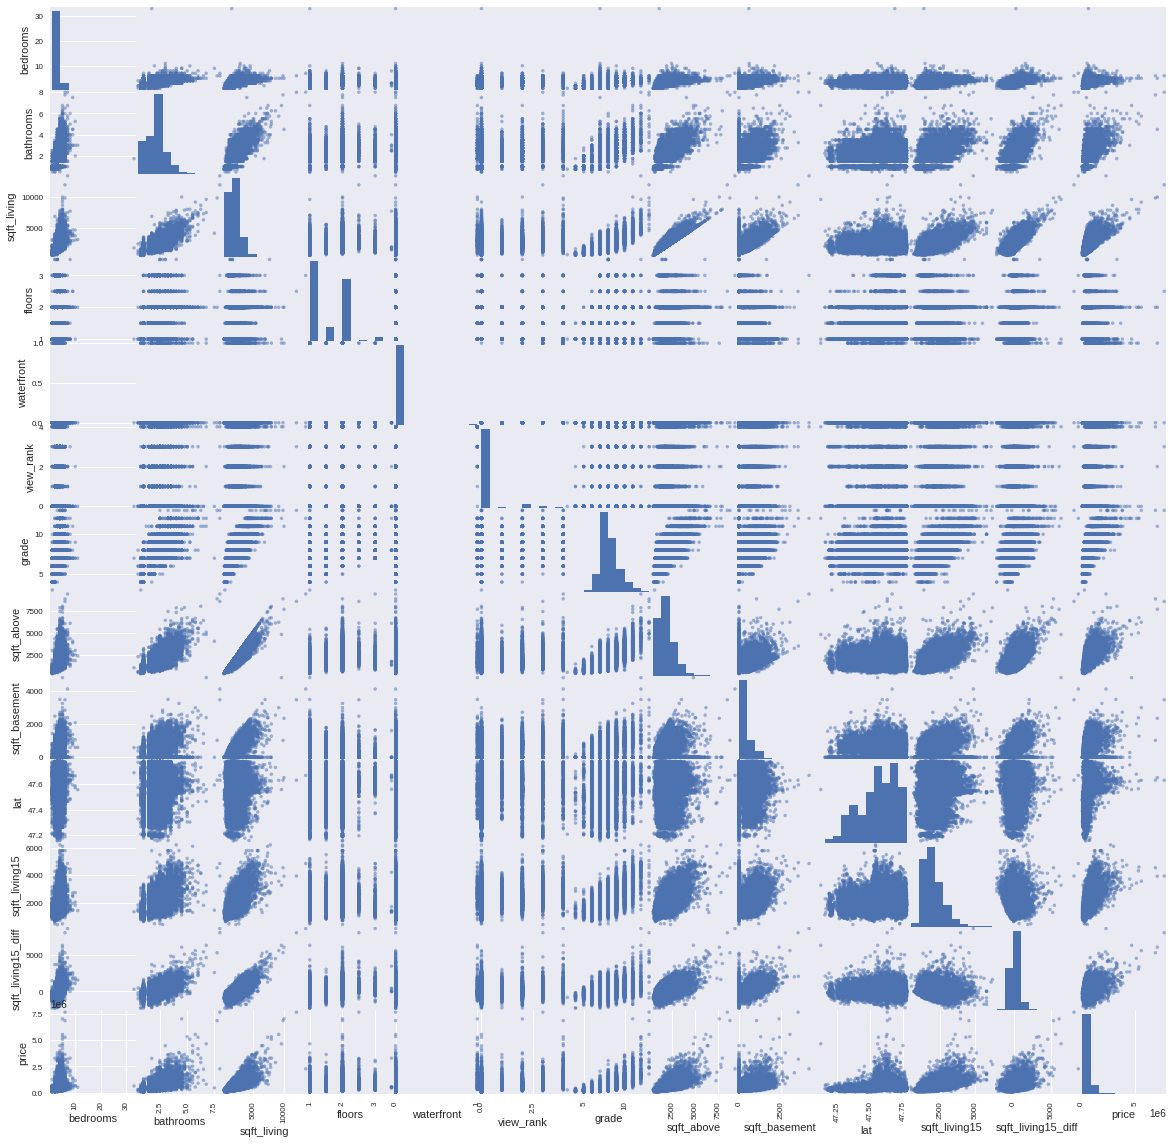

In [12]:
pd.plotting.scatter_matrix(correlated_df, figsize=(20,20))
plt.show()

### BLEH!    Do some log transforms on our skewed continuous variables.
* price, our target, is super skewed
* DROP sqft_living15_diff - it has negative values
* sqft_living15
* lat
* sqft_basement
* sqft_above
* floors
* sqft_living
* bedrooms
* bathrooms


### Categorical variables are:
* grade
* view_rank
* waterfront
* floors
* bedrooms
* bathrooms


<function matplotlib.pyplot.show(close=None, block=None)>

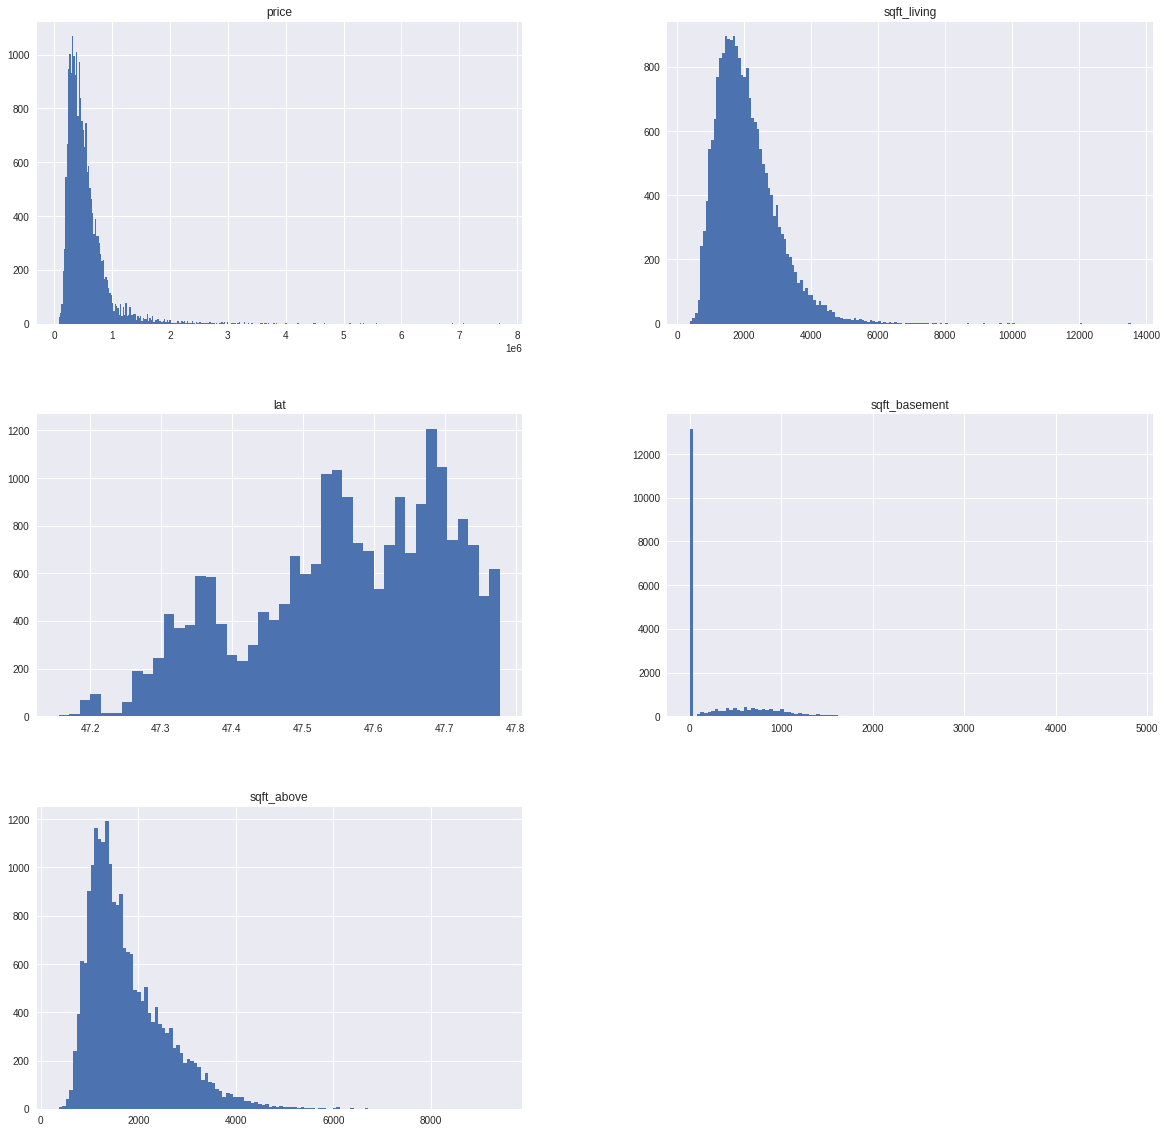

In [13]:
continuous_col_names = ['price','sqft_living', 'lat', 'sqft_basement', 'sqft_above']
continuous_df = correlated_df[continuous_col_names]
continuous_df.hist(figsize=[20, 20], bins='auto')
plt.show

In [14]:
# Note that sqft_basement has a huge number of zeros. 
# Drop this zero-inflated variable for now and just use the features which don't have this characteristic. 
continuous_df.drop(['sqft_basement'], axis=1, inplace=True)
continuous_df.head()

,price,sqft_living,lat,sqft_above
0,221900.0,1180,47.5112,1180
1,538000.0,2570,47.7210,2170
2,180000.0,770,47.7379,770
3,604000.0,1960,47.5208,1050
4,510000.0,1680,47.6168,1680



### Perform log transformations for those variables that need skew correction
Recall that a common option for transforming non-normal variable distributions is to try applying a logarithmic function and observe its impact of the distribution. Give it a go!

* price
* sqft_living
* lat
* sqft_above

In [17]:
# Now select those variables that need skew correction#
#non_norm_col_names = ['price','sqft_living', 'lat', 'sqft_above', 'bedrooms', 'bathrooms']
non_norm_col_names = ['price','sqft_living', 'lat', 'sqft_above']
non_norm_df = continuous_df[non_norm_col_names]

In [18]:
log_names = [f'{column}_log' for column in non_norm_df.columns]
cont_log_transformed_df = np.log(non_norm_df)
cont_log_transformed_df.columns = log_names
cont_log_transformed_df.head()

,price_log,sqft_living_log,lat_log,sqft_above_log
0,12.309982,7.073270,3.860965,7.073270
1,13.195614,7.851661,3.865372,7.682482
2,12.100712,6.646391,3.865726,6.646391
3,13.311329,7.580700,3.861168,6.956545
4,13.142166,7.426549,3.863186,7.426549


<function matplotlib.pyplot.show(close=None, block=None)>

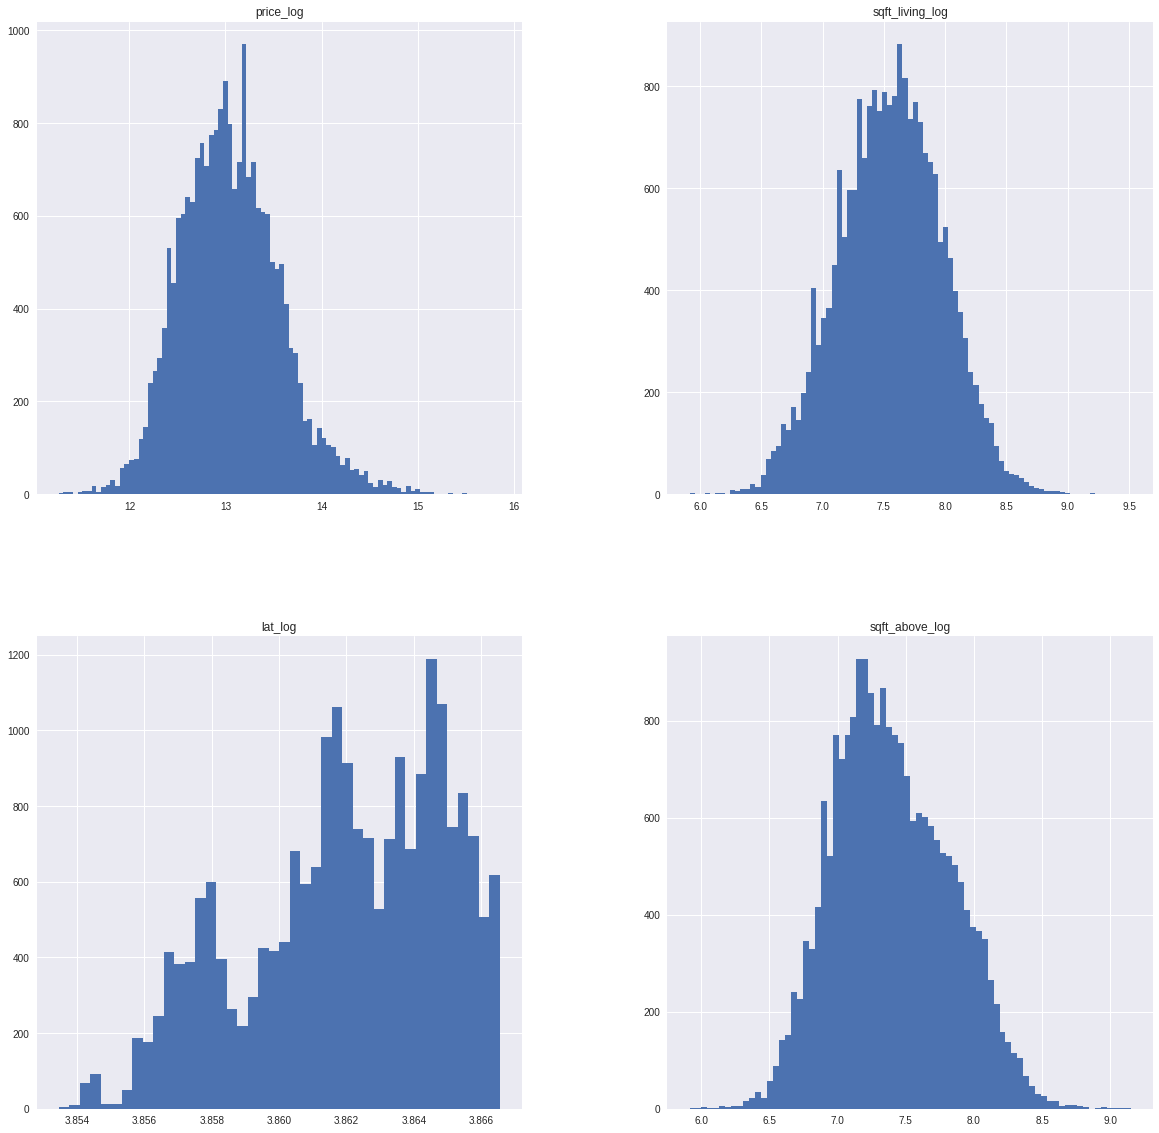

In [19]:
cont_log_transformed_df.hist(figsize=(20, 20), bins='auto')
plt.show

### Inspect the log transformed continuous variable distributions.  If the skew was improved, that variable will be standardized.and then included in the final feature space/set.
* price_log - our target so of course it will be included - IMPROVED 
* sqft_living_log - IMPROVED
* lat_log - no improvement - drop it
* sqft_above_log - IMPROVED

In [20]:
# normalize function for features that were log transformed
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

# drop features that didn't see skew improvement

cont_log_transformed_df.drop(['lat_log'], axis=1, inplace=True)
features_round_two = cont_log_transformed_df.apply(normalize)

<function matplotlib.pyplot.show(close=None, block=None)>

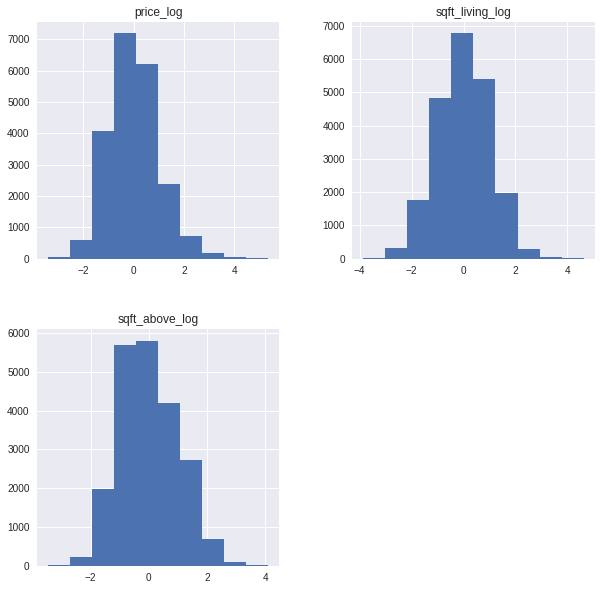

In [21]:
features_round_two.hist(figsize=(10, 10))
plt.show

### Now that we've got some likely features that have been transformed and normalized, create another model

In [22]:
print(features_round_two.describe())
print(correlated_features_above_2)

          price_log  sqft_living_log  sqft_above_log
count  2.142000e+04     2.142000e+04    2.142000e+04
mean   2.149541e-16    -1.573676e-15    1.464872e-15
std    1.000000e+00     1.000000e+00    1.000000e+00
min   -3.413040e+00    -3.864298e+00   -3.471287e+00
25%   -6.889096e-01    -6.761466e-01   -7.173971e-01
50%   -6.503934e-02     1.870703e-02   -1.033070e-01
75%    6.198888e-01     6.878971e-01    7.225070e-01
max    5.353786e+00     4.625088e+00    4.102957e+00
['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view_rank', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'sqft_living15', 'sqft_living15_diff', 'price']


In [23]:
feature_space_round_two_df = features_round_two
feature_space_round_two_df

,price_log,sqft_living_log,sqft_above_log
0,-1.417103,-1.129304,-0.756736
1,0.273605,0.706321,0.669188
2,-1.816608,-2.135982,-1.755890
3,0.494510,0.067332,-1.029941
4,0.171570,-0.296190,0.070150
...,...,...,...
21415,-0.493361,-0.516746,-0.148757
21416,-0.292224,0.454796,0.815523
21417,-0.282223,-1.472925,-1.097789
21418,-0.292224,-0.411249,-0.044048


In [24]:
target_round_two = 'price_log'
#feature_names_round_two = ['sqft_living_log','sqft_above_log','bedrooms_log', 'bathrooms_log']
feature_names_round_two = ['sqft_living_log','sqft_above_log']
feature_names_round_two

['sqft_living_log', 'sqft_above_log']

In [25]:
ols_round_two = check_model(feature_space_round_two_df, features_to_use=feature_names_round_two, target_col=target_round_two, show_summary=True)

sqft_living_log surpassed threshold with vif=3.9734976781966163
sqft_above_log surpassed threshold with vif=3.973497678196618
Model contains multicollinear features
                                 OLS Regression Results                                
Dep. Variable:              price_log   R-squared (uncentered):                   0.455
Model:                            OLS   Adj. R-squared (uncentered):              0.455
Method:                 Least Squares   F-statistic:                              8930.
Date:                Mon, 12 Oct 2020   Prob (F-statistic):                        0.00
Time:                        19:17:15   Log-Likelihood:                         -23898.
No. Observations:               21420   AIC:                                  4.780e+04
Df Residuals:                   21418   BIC:                                  4.782e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust      

### This new model with only 2 variable also has multicollinearity. Go back and add in the catagorical variables after doing one-hot encoding/getting dummy variables (and not falling into the dummy variable trap!)

In [26]:
feature_names_round_two

['sqft_living_log', 'sqft_above_log']

In [27]:
#feature_names_round_three = ['sqft_above_log','bedrooms_log','bathrooms_log']
feature_names_round_three = ['sqft_above_log']

In [29]:
ols_round_three = check_model(feature_space_round_two_df, features_to_use=feature_names_round_three, target_col=target_round_two, show_summary=True)

ValueError: zero-size array to reduction operation maximum which has no identity

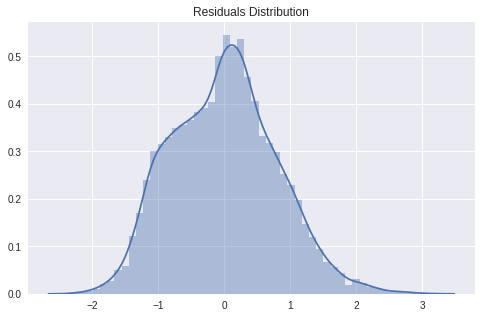

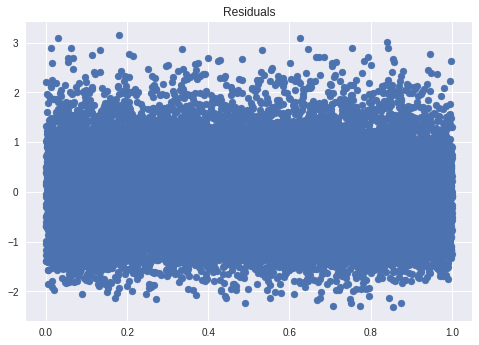

In [68]:
def plot_residuals(ols):
    residuals = ols.resid
    plt.figure(figsize=(8,5))
    plt.title('Residuals Distribution')
    sns.distplot(residuals)
    plt.show()
    plt.figure()
    x_axis = np.linspace(0, 1, len(residuals))
    plt.scatter(x_axis, residuals)
    plt.title('Residuals')
    plt.show()
    
    
plot_residuals(ols_round_three)

In [ ]:
# BELOW....is stuff from trying to create a model for a single zipcode ..may not need...

### Create a new model with cols that are above correlation threshold - there will be multicollinearity most likely so pick them off/mix and match until you get a good model


In [25]:
# try out with our cols above correlation threshold
ols = check_model(df, features_to_use=correlated_features_above_2, target_col=target, show_summary=True)


bedrooms surpassed threshold with vif=23.164768862981507
bathrooms surpassed threshold with vif=25.217406083389665
sqft_living surpassed threshold with vif=inf
floors surpassed threshold with vif=15.872845674096803
grade surpassed threshold with vif=138.20136308792732
sqft_above surpassed threshold with vif=671.33319333797
sqft_basement surpassed threshold with vif=46.84381313793166
lat surpassed threshold with vif=83.31909374910539
sqft_living15 surpassed threshold with vif=inf
sqft_living15_diff surpassed threshold with vif=inf
Model contains multicollinear features
                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.872
Model:                            OLS   Adj. R-squared (uncentered):              0.872
Method:                 Least Squares   F-statistic:                          1.324e+04
Date:                Thu, 08 Oct 2020   Prob (F-statistic):              

In [36]:
zipcodes = df['zipcode'].unique()
zipcodes

array([98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198, 98146,
       98038, 98007, 98115, 98107, 98126, 98019, 98103, 98002, 98133,
       98040, 98092, 98030, 98119, 98112, 98052, 98027, 98117, 98058,
       98001, 98056, 98166, 98023, 98070, 98148, 98105, 98042, 98008,
       98059, 98122, 98144, 98004, 98005, 98034, 98075, 98116, 98010,
       98118, 98199, 98032, 98045, 98102, 98077, 98108, 98168, 98177,
       98065, 98029, 98006, 98109, 98022, 98033, 98155, 98024, 98011,
       98031, 98106, 98072, 98188, 98014, 98055, 98039])

In [41]:
zip1_df = df[df['zipcode'] == 98045] #98045 is a zipcode by state park/conservation land
zip1_columns_correlations = get_columns_correlations(zip1_df, target)
zip1_columns_correlations_above_2 = get_columns_correlations_above_threshold(zip1_columns_correlations)
zip1_columns_correlations_above_2

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'view_rank',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'sqft_living15',
 'sqft_lot15',
 'sqft_living15_diff',
 'sqft_lot15_diff']

In [42]:
# I already know that sqft_living15_diff is related to sqft_living15 - don't include them both
zip1_whole_feature_space = zip1_columns_correlations_above_2
zip1_whole_feature_space.append(target)

In [43]:
# Let's hone in on some promising features
zip1_correlated_df = df[zip1_whole_feature_space]
zip1_correlated_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view_rank,condition,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,sqft_living15_diff,sqft_lot15_diff,price
0,3,1.00,1180,5650,1.0,0,3,7,1180,0,1955,1340,5650,-160,0,221900.0
1,3,2.25,2570,7242,2.0,0,3,7,2170,400,1951,1690,7639,880,-397,538000.0
2,2,1.00,770,10000,1.0,0,3,6,770,0,1933,2720,8062,-1950,1938,180000.0
3,4,3.00,1960,5000,1.0,0,5,7,1050,910,1965,1360,5000,600,0,604000.0
4,3,2.00,1680,8080,1.0,0,3,8,1680,0,1987,1800,7503,-120,577,510000.0


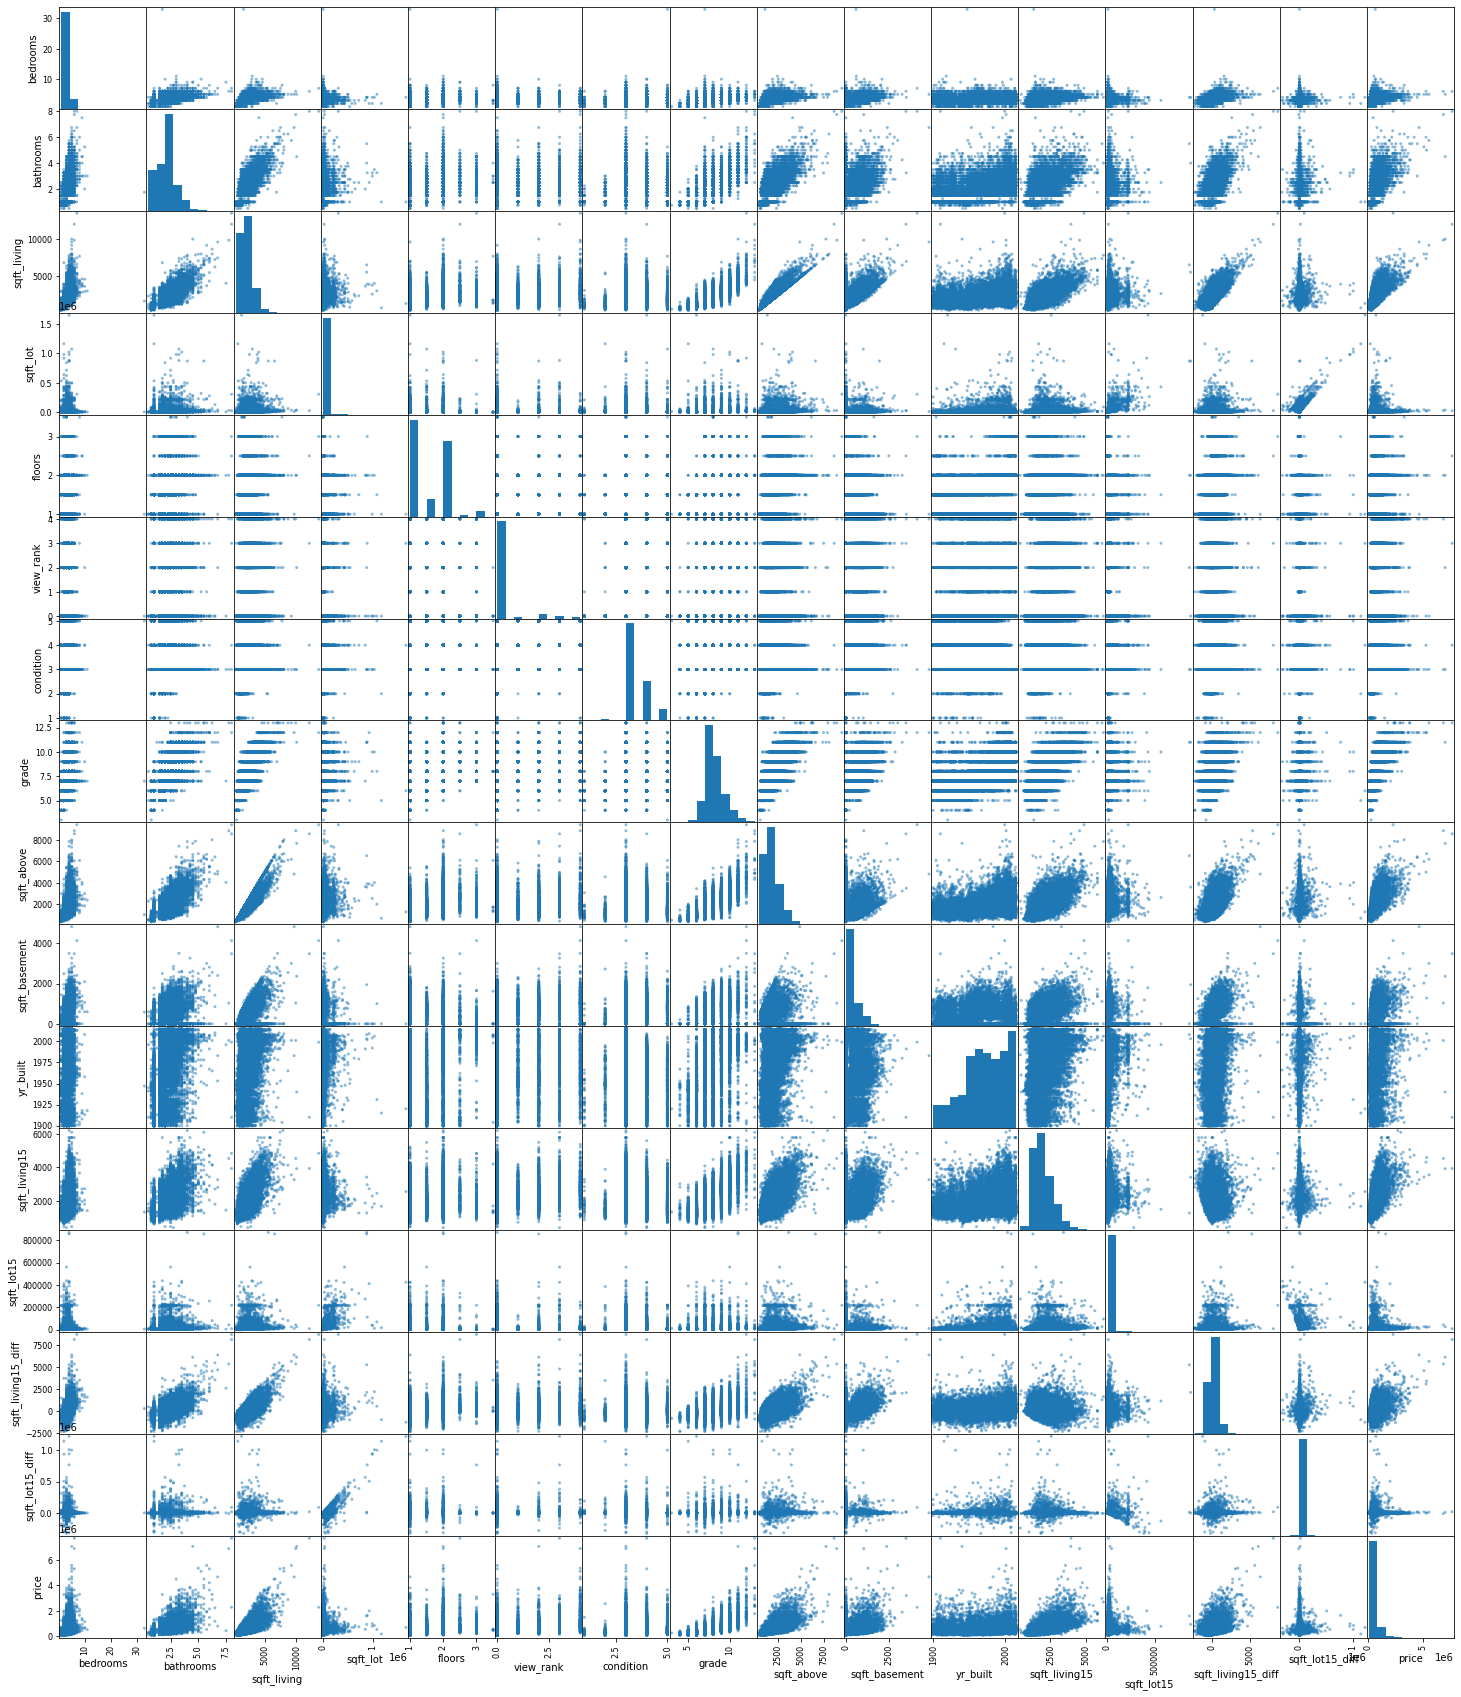

In [44]:
# plot a new scatter matrix with ONLY DATA FROM ONE ZIPCODE
pd.plotting.scatter_matrix(zip1_correlated_df, figsize=(25,30))
plt.show()

In [26]:
# any additional data cleaning for model building
